This is a data from the accounting system of an e-commerce company for one whole year.
====

The task is to automate and deploy machine learning to check the accounting data.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pd.options.display.width = 0
pd.options.display.max_rows = None
pd.options.display.float_format = "{:.2f}".format

In [2]:
data = pd.read_csv('C:\\Users\\SZ\\Dropbox\\Python Projekt Buchhaltung\\kontobuchungen2018.txt', 
                   header=0, sep=';', thousands='.', decimal=',', low_memory=False)

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362056 entries, 0 to 362055
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Konto                          362056 non-null  int64  
 1   Belegdatum                     362056 non-null  int64  
 2   BU-Schlüssel                   52583 non-null   float64
 3   Gegenkonto                     362056 non-null  int64  
 4   Buchungstext                   357709 non-null  object 
 5   Steuersatz                     362056 non-null  float64
 6   Belegfeld 1                    362056 non-null  object 
 7   Umsatz Soll                    362056 non-null  float64
 8   Umsatz Haben                   362056 non-null  float64
 9   WKZ eingeg. Umsatz             362056 non-null  object 
 10  Eingeg. Umsatz                 362056 non-null  float64
 11  Kurs                           362056 non-null  float64
 12  Stapel-Nr.                    

In [4]:
print(data.head())

    Konto  Belegdatum  BU-Schlüssel  Gegenkonto Buchungstext  Steuersatz  \
0   14000     1012018           nan       90080      EB-Wert        0.00   
1   90080     1012018           nan      107000      EB-Wert        0.00   
2  107000     1012018           nan       90080      EB-Wert        0.00   
3   14000     1012018           nan       90080      EB-Wert        0.00   
4   90080     1012018           nan      110000      EB-Wert        0.00   

  Belegfeld 1  Umsatz Soll  Umsatz Haben WKZ eingeg. Umsatz  ...  \
0           0       699.02          0.00                EUR  ...   
1           0         0.00        699.02                EUR  ...   
2           0       699.02          0.00                EUR  ...   
3           0      2250.19          0.00                EUR  ...   
4           0         0.00       2250.19                EUR  ...   

   Gesellschaftername  Beteiligtennummer Identifikationsnummer  \
0                 nan                nan                   nan   
1 

Throwing out irrelevant features

In [5]:
irrelevant_features = ['WKZ eingeg. Umsatz', 'Stapel-Nr.', 'BSNr', 'Herkunft-Kz', 'Belegfeld 2', 'KOST1 - Kostenstelle', 
                       'KOST2 - Kostenstelle', 'Kost-Menge', 'Stück', 'Gewicht', 'Auftragsnummer', 'EU-Land (Anzahlungen)', 
                       'Sachverhalt L+L (Anzahlungen)', 'Gesellschaftername', 'Beteiligtennummer', 'Identifikationsnummer', 
                       'Zeichnernummer', 'Buchungs GUID', 'Bezeichnung SoBil-Sachverhalt', 'Kennzeichen SoBil-Buchung', 'Leistungsdatum', 'Datum Zuord. Steuerperiode']
data.drop(irrelevant_features, inplace=True, axis=1)

Adding datetime feature and if zero NaT.

In [6]:
data['new_date'] = pd.to_datetime(data['Belegdatum'].astype(str), format='%d%m%Y', errors='coerce')
data.head()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date
0,14000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
1,90080,1012018,nan,107000,EB-Wert,0.00,0,0.00,699.02,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
2,107000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
3,14000,1012018,nan,90080,EB-Wert,0.00,0,2250.19,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
4,90080,1012018,nan,110000,EB-Wert,0.00,0,0.00,2250.19,0.00,0.00,nan,0,nan,0,0,0,2018-01-10


In [7]:
# data[data['new_date'].isnull()]

Adding unixtime.

In [8]:
data['date_unix'] = (data['new_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [9]:
data.head()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date,date_unix
0,14000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
1,90080,1012018,nan,107000,EB-Wert,0.00,0,0.00,699.02,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
2,107000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
3,14000,1012018,nan,90080,EB-Wert,0.00,0,2250.19,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
4,90080,1012018,nan,110000,EB-Wert,0.00,0,0.00,2250.19,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00


In [10]:
# data['Konto'].unique()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362056 entries, 0 to 362055
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Konto                        362056 non-null  int64         
 1   Belegdatum                   362056 non-null  int64         
 2   BU-Schlüssel                 52583 non-null   float64       
 3   Gegenkonto                   362056 non-null  int64         
 4   Buchungstext                 357709 non-null  object        
 5   Steuersatz                   362056 non-null  float64       
 6   Belegfeld 1                  362056 non-null  object        
 7   Umsatz Soll                  362056 non-null  float64       
 8   Umsatz Haben                 362056 non-null  float64       
 9   Eingeg. Umsatz               362056 non-null  float64       
 10  Kurs                         362056 non-null  float64       
 11  Buchungstyp (Anzahlungen) 

# TASK 1
---

Checking account 84000 Turnover if there are some bookings on the debit site which would be erroneous.

In [12]:
acc_84000 = data[data['Konto'] == 84000].count()
acc_84000

Konto                          32523
Belegdatum                     32523
BU-Schlüssel                      11
Gegenkonto                     32523
Buchungstext                   32523
Steuersatz                     32523
Belegfeld 1                    32523
Umsatz Soll                    32523
Umsatz Haben                   32523
Eingeg. Umsatz                 32523
Kurs                           32523
Buchungstyp (Anzahlungen)          0
USt-Schlüssel (Anzahlungen)    32523
EU-Steuersatz (Anzahlungen)        0
Erlöskonto (Anzahlungen)       32523
Skontotyp                      32523
Generalumkehr (GU)             32523
new_date                       32396
date_unix                      32396
dtype: int64

In [13]:
check_84000_soll = (data[(data['Konto'] == 84000) & (data['Umsatz Soll'] > 0)]).copy()

In [14]:
# check_84000_soll

In [15]:
check_84000_soll.describe()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),date_unix
count,326.00,326.00,0.00,326.00,326.00,326.00,326.00,326.00,326.00,0.00,326.00,0.00,326.00,326.00,326.00,325.00
mean,84000.00,16425514.93,nan,111819.18,19.00,204.75,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1526716711.38
std,0.00,8600654.54,nan,28193.81,0.00,1143.01,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,8946942.63
min,84000.00,1012018.00,nan,12000.00,19.00,0.01,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1515542400.00
25%,84000.00,10012018.00,nan,120000.00,19.00,19.24,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1519344000.00
50%,84000.00,17052018.00,nan,120000.00,19.00,44.45,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1524009600.00
75%,84000.00,23022018.00,nan,120000.00,19.00,100.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1532995200.00
max,84000.00,31122018.00,nan,126010.00,19.00,17875.56,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1546214400.00


In [16]:
check_84000_soll['BU-Schlüssel'].unique()

array([nan])

In [17]:
check_84000_soll['Gegenkonto'].unique()

array([ 12000, 116010, 112030, 102020, 126010, 120000, 114010, 118020,
       106010, 107011,  15910, 108010, 112012], dtype=int64)

In [18]:
check_gegenkonto = check_84000_soll.groupby(['Gegenkonto']).count()
check_gegenkonto

,Konto,Belegdatum,BU-Schlüssel,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date,date_unix
Gegenkonto,,,,,,,,,,,,,,,,,,
12000,23,23,0,23,23,23,23,23,23,23,0,23,0,23,23,23,23,23
15910,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
102020,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
106010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
107011,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
108010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
112012,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
112030,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
114010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1


In [19]:
check_84000_soll['Steuersatz'].unique()

array([19.])

In [20]:
check_belegfeld = check_84000_soll['Belegfeld 1']
# check_belegfeld

In [21]:
check_btext = check_84000_soll['Buchungstext']
# check_btext

In [22]:
check_stsatz = check_84000_soll['Steuersatz']
# check_stsatz

# TASK 2
---


Anomaly detection of bookings on the account 84000 false on debet.

* Preparing data

In [23]:
irr_f = ['Belegdatum', 'Eingeg. Umsatz', 'Kurs', 'new_date', 'Generalumkehr (GU)', 'BU-Schlüssel', 'Buchungstext', 
         'Belegfeld 1', 'Buchungstyp (Anzahlungen)', 'EU-Steuersatz (Anzahlungen)', 'Erlöskonto (Anzahlungen)', 'Skontotyp',
        'USt-Schlüssel (Anzahlungen)']
data_2 = data.drop(irr_f, axis=1)

In [24]:
data_2.head()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix
0,14000,90080,0.00,699.02,0.00,1515542400.00
1,90080,107000,0.00,0.00,699.02,1515542400.00
2,107000,90080,0.00,699.02,0.00,1515542400.00
3,14000,90080,0.00,2250.19,0.00,1515542400.00
4,90080,110000,0.00,0.00,2250.19,1515542400.00


Adding a label column 'acc_84000_corr1' with booolean labels: 0 - erroneous booking, 1 - correct booking.

In [25]:
data_2['acc_84000_corr1'] = (data_2['Konto'] == 84000) & (data_2['Umsatz Soll'] == 0)
data_2['acc_84000_corr1'] = data_2['acc_84000_corr1'].astype('int')

In [26]:
data_2['Steuersatz'].unique()

array([ 0. , 19. ,  7. , 20. , 13. , 10. ,  2.1, 21. ])

In [27]:
data_2 = data_2.drop(data_2[data_2['Steuersatz'] == 2.1].index)

Filling out bookings without date with one same = 1518480000.00

In [28]:
data_2_prep = data_2[data_2['Konto'] == 84000].reset_index()
throw_index = 'index'
data_2_prep = data_2_prep.drop(throw_index, axis=1)
# data_2_prep[data_2_prep['date_unix'].replace({pd.NaT: '1518480000.00'})]
data_2_prep = data_2_prep.fillna(1518480000.00)

In [29]:
data_2_prep.head(n=50)

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1
0,84000,12000,19.00,3.28,0.00,1515542400.00,0
1,84000,12000,19.00,3.28,0.00,1515542400.00,0
2,84000,12000,19.00,6.18,0.00,1515542400.00,0
3,84000,12000,19.00,6.55,0.00,1515542400.00,0
4,84000,12000,19.00,8.32,0.00,1515542400.00,0
5,84000,12000,19.00,10.92,0.00,1515542400.00,0
6,84000,12000,19.00,11.60,0.00,1515542400.00,0
7,84000,12000,19.00,11.76,0.00,1515542400.00,0
8,84000,12000,19.00,16.10,0.00,1515542400.00,0
9,84000,12000,19.00,17.23,0.00,1515542400.00,0


Checking data for NaN

In [30]:
data_2_prep[data_2_prep.date_unix.isnull()]

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1


In [31]:
data_2_prep.describe()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1
count,32523.00,32523.00,32523.00,32523.00,32523.00,32523.00,32523.00
mean,84000.00,119852.17,19.00,2.00,58.16,1527503695.38,0.99
std,0.00,3690.51,0.00,116.18,217.60,9628328.46,0.10
min,84000.00,12000.00,19.00,-633.76,-1509.90,1515024000.00,0.00
25%,84000.00,120000.00,19.00,0.00,19.24,1518480000.00,1.00
50%,84000.00,120000.00,19.00,0.00,41.18,1525651200.00,1.00
75%,84000.00,120000.00,19.00,0.00,79.83,1536192000.00,1.00
max,84000.00,126010.00,19.00,17875.56,35486.50,1546214400.00,1.00


ok, now I check how many correct bookings we have: 32193 out of 32523 and 330 erroneous bookings.

In [32]:
data_2_prep[(data_2_prep['acc_84000_corr1'] == 1)].count()

Konto              32193
Gegenkonto         32193
Steuersatz         32193
Umsatz Soll        32193
Umsatz Haben       32193
date_unix          32193
acc_84000_corr1    32193
dtype: int64

In [33]:
data_2_prep[(data_2_prep['acc_84000_corr1'] == 0)].count()

Konto              330
Gegenkonto         330
Steuersatz         330
Umsatz Soll        330
Umsatz Haben       330
date_unix          330
acc_84000_corr1    330
dtype: int64

Let's have a quick look at the distribution of data. 

We can see that there at least one outlier far from the main data. But we will leave as it is cause in fact it is what we want to detect as well.

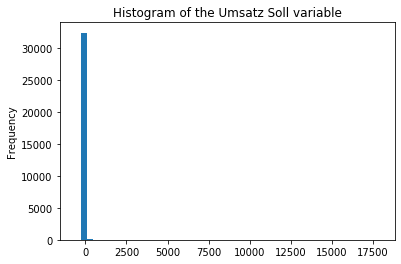

In [34]:
import seaborn as sns

data_2_prep['Umsatz Soll'].plot.hist(
    bins = 50,
    title = "Histogram of the Umsatz Soll variable"
)


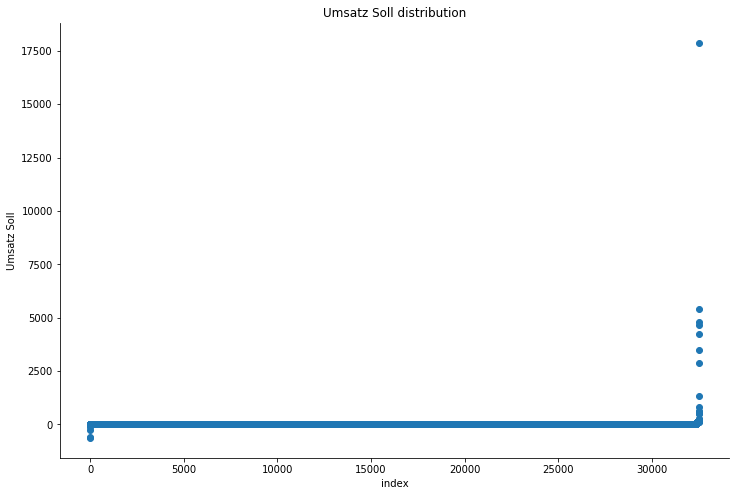

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(range(data_2_prep.shape[0]), np.sort(data_2_prep['Umsatz Soll'].values))
plt.xlabel('index')
plt.ylabel('Umsatz Soll')
plt.title("Umsatz Soll distribution")
sns.despine()

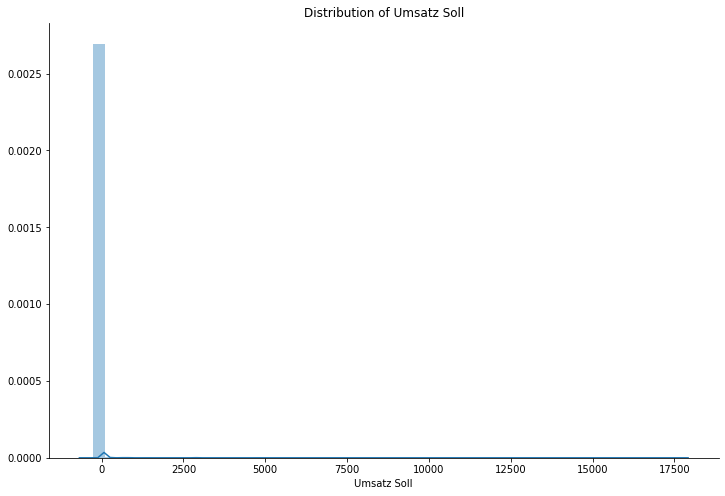

In [36]:
plt.figure(figsize=(12,8))
sns.distplot(data_2_prep['Umsatz Soll'])
plt.title("Distribution of Umsatz Soll")
sns.despine()

There is a huge positive skew in the data. The kurtosis is huge and therefore indicating outliers.

In [37]:
print("Skewness: ", data_2_prep['Umsatz Soll'].skew())
print("Kurtosis: ", data_2_prep['Umsatz Soll'].kurt())

Skewness:  122.13981050013857
Kurtosis:  17634.595794919525


## Model 1 - unsupervised


### Isolation forest

In [ ]:
from sklearn.model_selection import train_test_split
predict = 'acc_84000_corr1'

X = data_2_prep.drop([predict], axis=1)
y = data_2_prep[predict]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=17)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_test)

So let's check how many wrong bookings (0) are in the test split:

In [ ]:
y_test[y_test == 0].count()

In [ ]:
from sklearn.ensemble import IsolationForest

clf_if = IsolationForest(contamination=0.15, random_state=42, n_jobs=-1)
clf_if.fit(X_train[['Umsatz Soll']])

ok. let's check how the model can predict. Isolated observations are "-1". We can see that the model discovered correctly the anomaly.

In [ ]:
some_X_test = X_test.iloc[150:185]
some_y_test = y_test.iloc[150:185]

some_pred = clf_if.predict(some_X_test[['Umsatz Soll']])
print("\nSome test predictions:\n", some_pred)
print("\nSome y_test:\n", list(some_y_test))

In [ ]:
predictions = clf_if.predict(X_test[['Umsatz Soll']])

In [ ]:
X_test['scores'] = clf_if.decision_function(X_test[['Umsatz Soll']])
X_test['anomaly'] = clf_if.predict(X_test[['Umsatz Soll']])
X_test['y_test'] = y_test
X_test.head()

ok, so I had to do first model with train_test_split (random_state=42) and the second model with random_state=17. The problem in ithe first model was that there were 79 anomalies found but we know from y_test we have 83 incorect bookings. So I checked the not found errors and they were all and only negative values. So I changed the random_state in second model and I was lucky it worked perfect, train data had some negative values so this time also predictions on the test data were ok and negative values were found. With the second model we found 82 of 83 errors!!!

In [ ]:
(X_test[X_test['anomaly'] == -1]).count()

So let's  see which errors where not found by the model.  In the first model we can see that only minus (negative) values in 'Umsatz Soll' where not found. In the second model only one error was not found and it was a value of 'Umsatz Soll' of 0.01.

In [ ]:
X_test[X_test['y_test'] == 0]

We could check how many negative values there are in the data to try to explain why only negative values were not found. So in fact there are only 4 negative values and unfortunetely all are in X_test.

In [ ]:
data_2_prep[(data_2_prep['Umsatz Soll'] < 0)].count()

## Model 2 unsupervised


### DBSCAN

In [ ]:
soll_haben = data_2_prep[["Umsatz Soll", "Konto"]]
soll_haben.plot.scatter(x = "Umsatz Soll", y = "Konto")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
soll_haben = scaler.fit_transform(soll_haben)
soll_haben = pd.DataFrame(soll_haben, columns = ["Umsatz Soll", "Konto"])

soll_haben.plot.scatter(x = "Umsatz Soll", y = "Konto")

In [ ]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(
    eps = 0.0001,
    metric="euclidean",
    min_samples = 100,
    n_jobs = -1)

clusters = outlier_detection.fit_predict(soll_haben)

Let's see how many clusters DBSCAN build and what are the data points from outliers cluster (-1).

So there is one cluster and 328 outliers from 330 overall. Not bad!!!

In [ ]:
from collections import Counter
outlier_df = pd.DataFrame(data_2_prep)
print(Counter(outlier_detection.labels_), '\n')
print(outlier_df[outlier_detection.labels_ == -1])

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('Accent')
soll_haben.plot.scatter(
    x = "Umsatz Soll",
    y = "Konto",
    c = clusters,
    cmap = cmap,
    colorbar = False
)

## Model 3 supervised

### Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
predict_rf = 'acc_84000_corr1'

X_rf = data_2_prep.drop([predict_rf], axis=1)
y_rf = data_2_prep[predict_rf]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, stratify=y_rf, random_state=17)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_jobs=-1, random_state=42)
forest.fit(X_train_rf, y_train_rf)

# print("\n\tCross validation for Random Forest:")
# forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=tscv)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

predictions = forest.predict(X_test_rf)

The beauty of RandomForest we can check which features were important for the model. Not surprisly  Gegenkonto and a bit surprise Buchungstext were the most important.

In [ ]:
feature_names = list(data)
print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), feature_names),reverse=True))

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest, X_test_rf, y_test_rf)

It looks quite amazing! RandomForest recognized 82 out of 83 errors exactly the same result like Isolation forest just with the difference that RandomForest is supervised technic.